# 1. Download and Installations

In [ ]:
#!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

#!unzip "glove.840B.300d.zip"

In [ ]:
path_to_drive = "drive/MyDrive/TSD/"

In [ ]:
import nltk
nltk.download('stopwords')
!pip3 install transformers
!pip install keras-self-attention
#!pip3 install keras-multi-head

# 2. Load GPT2 and Roberta and define feature representations

In [ ]:
from transformers import GPT2Tokenizer, GPT2Model, RobertaTokenizer, RobertaModel
from tqdm import tqdm
import numpy as np

GPT2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
GPT2_model = GPT2Model.from_pretrained('gpt2')

roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base')

__vectors__gpt2__ = {}
__vectors__roberta__ = {}

def get_roberta_vec(X):
    try:
        vec = __vectors__roberta__[X]
        return vec
    except:
        inputs = roberta_tokenizer(X, return_tensors="pt")
        outputs = roberta_model(**inputs)
        vec = np.mean(outputs[0].detach().numpy(),  axis=1)[0]
        __vectors__roberta__[X] = vec
        return vec

def get_gpt2_vector(word):
    try:
        vec = __vectors__gpt2__[word]
        return vec
    except:
        inputs = GPT2_tokenizer(word, return_tensors="pt")
        outputs = GPT2_model(**inputs)
        #outputs = model(**inputs)[0][0]
        #vec = sum(outputs.detach().numpy())/outputs.shape[0]
        vec = np.average(outputs[0].detach().numpy(), axis=1)[0]
        __vectors__gpt2__[word] = vec
        return vec

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np
from tqdm import tqdm
from nltk.stem.porter import *
stemmer = PorterStemmer()

special_chars = ['O', '4', '͞', 'ü', '😞', '»', '”', '\x7f', '"', '7', '*', '8', ')',
      '😂', '💀', '{', '0', 'ʻ', '💨', '•', '#', '_', '😊', '😜', 'ó', '😅', 
      '¬', '☠', '🙄', '😉', '😆', '―','(', '.', '?', '😵', '💥', ':', '🆘',
      '$', '=', '+', ';', '🔥', '😁','`', 'ï', '2', 'ê', 'é', '3', '-', '🤥',
      '⚽', 'É', '️', '!', '5', '✭', '9', '😈', 'ˈ', '😬', '@', '«', '/', '▀', '’',
      '😡', '1', '%', ',', '&', '6', '\\', ']', "'", '[', '^', '}', '⚾', '\u200b',
       '☭', '☹', '<', 'l', '™', '👎']
 
 
F_cleaner = lambda x: stemmer.stem(''.join([w for w in x if w not in special_chars ]).lower())
 

def make_vecs(embeddings_index, embed_size, word_index):
    embedding_matrix = np.zeros((len(word_index), embed_size))
    existed_w = 0
    for word, i in tqdm(word_index.items()):
        embedding_vector_glove = embeddings_index.get(F_cleaner(word))
        embedding_vector_gpt2 = get_gpt2_vector(word)
        embedding_vector_roberta = get_roberta_vec(word)
        if embedding_vector_glove is None:
            embedding_vector_glove = np.zeros(300)
        
        embedding_matrix[i] = np.concatenate([embedding_vector_gpt2+embedding_vector_roberta, 
                                              embedding_vector_glove])
    return embedding_matrix

# 3. Loading Dataset

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import cross_validator as cross_validator
import datahandler as datahandler
from datamodel import DataModel
import outputmaker as outputmaker
import metrics as metrics

trial = datahandler.load_train(path_to_drive+'tsd_trial.csv', verbose=True)
train = datahandler.load_train(path_to_drive+'tsd_train.csv', verbose=True)
test = datahandler.load_train(path_to_drive+'tsd_test.csv', verbose=True)

,spans,text
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",Because he's a moron and a bigot. It's not any...
1,"[29, 30, 31, 32, 33, 34]",How about we stop protecting idiots and let na...
2,"[166, 167, 168, 169, 170, 171]","If people were smart, they would Boycott th..."


,spans,text
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",Another violent and aggressive immigrant killi...
1,"[33, 34, 35, 36, 37, 38, 39]","I am 56 years old, I am not your fucking junio..."
2,"[0, 1, 2, 3]","Damn, a whole family. Sad indeed."


,text,spans
0,That's right. They are not normal. And I am st...,[]
1,"""Watch people die from taking away their healt...",[]
2,tens years ago i contacted the PDR and suggest...,[]


In [ ]:
datamodel = DataModel(model='crf', remove_stop_words=False)

output_maker = outputmaker.crf_output

evaluator = metrics

In [ ]:
X_train, y_train, train_taboo_words, train_texts = cross_validator.load_data(train, 
                                                    [i for i in range(train.shape[0])],
                                                    datamodel, logger=True)

X_test, y_test, test_taboo_words, test_texts = cross_validator.load_data(trial, 
                                                    [i for i in range(trial.shape[0])], 
                                                    datamodel, logger=True)

X_test_fn, y_test_fn, _, test_texts_fn = cross_validator.load_data(test, 
                                                    [i for i in range(test.shape[0])], 
                                                    datamodel, logger=True)

100%|██████████| 2000/2000 [01:15<00:00, 26.47it/s]


In [ ]:
X_test[0]

[('Because', 'IN', 'normal', [0, 1, 2, 3, 4, 5, 6]),
 ('he', 'PRP', 'normal', [8, 9]),
 ('a', 'DT', 'normal', [13]),
 ('moron', 'NN', 'toxic', [15, 16, 17, 18, 19]),
 ('and', 'CC', 'normal', [21, 22, 23]),
 ('a', 'DT', 'normal', [25]),
 ('bigot', 'NNP', 'toxic', [27, 28, 29, 30, 31]),
 ('It', 'PRP', 'normal', [34, 35]),
 ('not', 'RB', 'normal', [39, 40, 41]),
 ('any', 'DT', 'normal', [43, 44, 45]),
 ('more', 'RBR', 'normal', [47, 48, 49, 50]),
 ('complicated', 'JJ', 'normal', [52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]),
 ('than', 'IN', 'normal', [64, 65, 66, 67]),
 ('that', 'DT', 'normal', [69, 70, 71, 72])]

# 4. Preprocessing


In [ ]:
from tqdm import tqdm 
from nltk.stem.porter import *
stemmer = PorterStemmer()

special_chars = ['O', '4', '͞', 'ü', '😞', '»', '”', '\x7f', '"', '7', '*', '8', ')',
      '😂', '💀', '{', '0', 'ʻ', '💨', '•', '#', '_', '😊', '😜', 'ó', '😅', 
      '¬', '☠', '🙄', '😉', '😆', '―','(', '.', '?', '😵', '💥', ':', '🆘',
      '$', '=', '+', ';', '🔥', '😁','`', 'ï', '2', 'ê', 'é', '3', '-', '🤥',
      '⚽', 'É', '️', '!', '5', '✭', '9', '😈', 'ˈ', '😬', '@', '«', '/', '▀', '’',
      '😡', '1', '%', ',', '&', '6', '\\', ']', "'", '[', '^', '}', '⚾', '\u200b',
       '☭', '☹', '<', 'l', '™', '👎']
 
 
F_cleaner = lambda x: ''.join([w for w in x if w not in special_chars ]).lower()
 
     
def cleaning(X, clean=True):
    cleaned_x = []
    for words in tqdm(X):
        cleaned_words = []
        for word in words :
            w, pos, tag, span = word
            if clean:
                cleaned_w = F_cleaner(w)
            else:
                cleaned_w = w.lower()
            if len(cleaned_w) != 0:
                cleaned_words.append((cleaned_w, pos, tag, span))
                #cleaned_words.append((stemmer.stem(cleaned_w), pos, tag, span) )
        cleaned_x.append(cleaned_words)
    return cleaned_x

In [ ]:
X_train = cleaning(X_train, clean=False)
X_test_clean = cleaning(X_test, clean=False)
X_test_fn = cleaning(X_test_fn, clean=False)

100%|██████████| 2000/2000 [00:00<00:00, 60180.41it/s]


# 5. Preprations for modeling

In [ ]:
words = set([w for x in X_train + X_test_clean+X_test_fn for w, tag, label, span in x])
tags = set([tag for x in X_train for w, pos, tag, span in x])
 
n_tags = len(tags)
n_words = len(words)
 
print("n_tags:{}, n_words:{}\n".format(n_tags, n_words))
 
max_len = max([len(x) for x in X_train+X_test_clean+X_test_fn])
print("max_len:{} ".format(max_len))
 
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
 
idx2word = {i: w for w, i in word2idx.items()}
 
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}
 
print("word2idx['fuck']:{},  tag2idx['normal']:{}\n".format(word2idx["fuck"], tag2idx["normal"]))

n_tags:2, n_words:21788

max_len:215 
word2idx['fuck']:17710,  tag2idx['normal']:1



In [ ]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.utils import to_categorical
 
X_word = [[word2idx[w[0]] for w in s] for s in tqdm(X_train)]
X_word = pad_sequences(maxlen=max_len, sequences=X_word, 
                       value=word2idx["PAD"], padding='post', truncating='post')
 
 
y_ = [[tag2idx[w[2]] for w in s] for s in X_train]
 
print("len(y):, ", len(y_))
 
y_ = pad_sequences(maxlen=max_len, sequences=y_, 
                  value=tag2idx["PAD"], padding='post', truncating='post')
 
y = [to_categorical(i, num_classes=n_tags+1) for i in y_]

100%|██████████| 7939/7939 [00:00<00:00, 145844.90it/s]


len(y):,  7939


In [ ]:
X_word_tr, y_tr = X_word, y

# 6. Multi-Feature Representation

In [ ]:
max_features = len(word2idx)
max_features

21790

In [ ]:
embeddings_index = {}
f = open(path_to_drive+'glove.840B.300d.txt')
for line in tqdm(f):
    values = line.split()
    word = ' '.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    embeddings_index[word] = coefs.reshape(-1)
f.close()

2196017it [02:44, 13346.56it/s]


In [ ]:
#comment this block if you dont have preloaded vectors - next cell will create it
import pickle 

def load_pkl(path):
    '''load pickle data from specified path'''
    with open(path, "rb") as f:
        pkl = pickle.load(f)
    return pkl

__vectors__gpt2__ = load_pkl(path_to_drive+"__vectors__gpt2__.sav")
__vectors__roberta__ = load_pkl(path_to_drive+"__vectors__roberta__.sav")

In [ ]:
embed_size = 768 +300

embedding_vector = make_vecs(embeddings_index, embed_size, word2idx)

100%|██████████| 21790/21790 [00:00<00:00, 59093.73it/s]


# 7. Modeling

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D, GRU, SimpleRNN, SpatialDropout1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D, GlobalMaxPool1D, Activation
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.metrics import classification_report
import tensorflow_addons as tfa
from keras_self_attention import SeqSelfAttention

import keras
print("Keras:", keras.__version__)
import tensorflow as tf
print("tf:",tf.__version__)

Keras: 2.4.3
tf: 2.4.0


In [ ]:
word_in = Input(shape=(max_len,))
emb_word = Embedding(max_features, embed_size, weights=[embedding_vector], trainable=False)(word_in)

x = Bidirectional(tf.compat.v1.keras.layers.CuDNNGRU(units=100, return_sequences=True))(x)
x = Bidirectional(tf.compat.v1.keras.layers.CuDNNGRU(units=100, return_sequences=True))(x)

x = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                       kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                       bias_regularizer=tf.keras.regularizers.l1(1e-4),
                       attention_regularizer_weight=1e-4,
                       name='Attention')(x)

x = TimeDistributed(Dense(50, activation="tanh"))(x)

out = TimeDistributed(Dense(n_tags + 1, activation="sigmoid"))(x)

model = Model(word_in, out)
 
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 215)]             0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 215, 1068)         23271720  
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 215, 50)           267050    
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 215, 200)          91200     
_________________________________________________________________
Attention (SeqSelfAttention) (None, 215, 200)          40001     
_________________________________________________________________
time_distributed_18 (TimeDis (None, 215, 50)           10050     
_________________________________________________________________
time_distributed_19 (TimeDis (None, 215, 3)            153 

In [ ]:
history = model.fit(X_word_tr, np.array(y_), batch_size=32, epochs=10, validation_split=0.02, verbose=1)

Epoch 1/5
244/244 [==============================] - 15s 49ms/step - loss: 0.3752 - accuracy: 0.8934 - val_loss: 0.1029 - val_accuracy: 0.9804
Epoch 2/5
244/244 [==============================] - 8s 35ms/step - loss: 0.1076 - accuracy: 0.9840 - val_loss: 0.0760 - val_accuracy: 0.9865
Epoch 3/5
244/244 [==============================] - 8s 35ms/step - loss: 0.0719 - accuracy: 0.9869 - val_loss: 0.0638 - val_accuracy: 0.9872
Epoch 4/5
244/244 [==============================] - 9s 35ms/step - loss: 0.0612 - accuracy: 0.9883 - val_loss: 0.0592 - val_accuracy: 0.9892
Epoch 5/5
244/244 [==============================] - 8s 35ms/step - loss: 0.0605 - accuracy: 0.9885 - val_loss: 0.0559 - val_accuracy: 0.9894


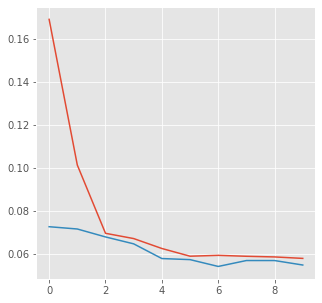

In [ ]:
hist = pd.DataFrame(history.history)

plt.style.use("ggplot")
plt.figure(figsize=(5,5))
#plt.plot(hist["acc"])
#plt.plot(hist["val_acc"])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

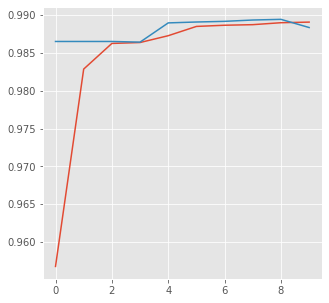

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(5,5))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()

# 8. Prediction over Validation

In [ ]:
X_test_clean[0]

[('because', 'IN', 'normal', [0, 1, 2, 3, 4, 5, 6]),
 ('he', 'PRP', 'normal', [8, 9]),
 ('a', 'DT', 'normal', [13]),
 ('moron', 'NN', 'toxic', [15, 16, 17, 18, 19]),
 ('and', 'CC', 'normal', [21, 22, 23]),
 ('a', 'DT', 'normal', [25]),
 ('bigot', 'NNP', 'toxic', [27, 28, 29, 30, 31]),
 ('it', 'PRP', 'normal', [34, 35]),
 ('not', 'RB', 'normal', [39, 40, 41]),
 ('any', 'DT', 'normal', [43, 44, 45]),
 ('more', 'RBR', 'normal', [47, 48, 49, 50]),
 ('complicated', 'JJ', 'normal', [52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]),
 ('than', 'IN', 'normal', [64, 65, 66, 67]),
 ('that', 'DT', 'normal', [69, 70, 71, 72])]

In [ ]:
no = []
for s in X_test_clean:
    x_s = []
    for w in s:
        try:
            x_s.append(word2idx[w[0]])
        except:
            no.append(w)

X_word_test = [[word2idx[w[0]] if w[0] in word2idx else word2idx["UNK"] for w in s] for s in tqdm(X_test_clean)]

print("not in word2idx:{}, length of X_word_test:{}".format(len(no), len(X_word_test)))

X_word_test = pad_sequences(maxlen=max_len, sequences=X_word_test, 
                            value=word2idx["PAD"], padding='post', truncating='post')

100%|██████████| 690/690 [00:00<00:00, 79568.62it/s]

not in word2idx:0, length of X_word_test:690


In [ ]:
y_pred_test = model.predict(X_word_test)

In [ ]:
y_test_preds, probas = [], []
for i in tqdm(range(y_pred_test.shape[0])):
    p = np.argmax(y_pred_test[i], axis=-1)
    preds, proba = [],[]
    lenght = 0
    for w, pred in zip(X_word_test[i], p):
        if w != 0:
            preds.append(idx2tag[pred])
            lenght+=1
    y_test_preds.append(preds)
    probas.append(y_pred_test[i][:lenght])

print("predicted test size:", len(y_test_preds))

predictions = output_maker(X_test, test_texts, y_test_preds)

f1, p, r = evaluator.evaluate(gold = y_test, predictions = predictions)

print("F1:{}, \t P:{}, \t R:{}".format(f1, p, r))

100%|██████████| 690/690 [00:00<00:00, 2679.18it/s]

predicted test size: 690
F1:0.6383529150114166, 	 P:0.7356519921450859, 	 R:0.6441146133732796


# 9. Prediction on Test

In [ ]:
X_test_fn[49]

[('thank', 'VBP', 'normal', [0, 1, 2, 3, 4]),
 ('you', 'PRP', 'normal', [6, 7, 8]),
 ('i', 'PRP', 'normal', [11]),
 ('so', 'RB', 'normal', [15, 16]),
 ('sick', 'JJ', 'normal', [18, 19, 20, 21]),
 ('and', 'CC', 'normal', [23, 24, 25]),
 ('tired', 'JJ', 'normal', [27, 28, 29, 30, 31]),
 ('of', 'IN', 'normal', [33, 34]),
 ('people', 'NNS', 'normal', [36, 37, 38, 39, 40, 41]),
 ('acting', 'VBG', 'normal', [43, 44, 45, 46, 47, 48]),
 ('like', 'IN', 'normal', [50, 51, 52, 53]),
 ('the', 'DT', 'normal', [55, 56, 57]),
 ('military', 'NN', 'normal', [59, 60, 61, 62, 63, 64, 65, 66]),
 ('is', 'VBZ', 'normal', [68, 69]),
 ('filled', 'VBN', 'normal', [71, 72, 73, 74, 75, 76]),
 ('with', 'IN', 'normal', [78, 79, 80, 81]),
 ('precious', 'JJ', 'normal', [83, 84, 85, 86, 87, 88, 89, 90]),
 ('snowflakes', 'NNS', 'normal', [92, 93, 94, 95, 96, 97, 98, 99, 100, 101]),
 ('that', 'WDT', 'normal', [103, 104, 105, 106]),
 ('will', 'MD', 'normal', [108, 109, 110, 111]),
 ('be', 'VB', 'normal', [113, 114]),
 (

In [ ]:
no = []
for s in X_test_fn:
    x_s = []
    for w in s:
        try:
            x_s.append(word2idx[w[0]])
        except:
            no.append(w)

X_word_test_fn = [[word2idx[w[0]] if w[0] in word2idx else word2idx["UNK"] for w in s] for s in tqdm(X_test_fn)]

print("\nnot in word2idx:{}, length of X_word_test:{}".format(len(no), len(X_word_test_fn)))

X_word_test_fn = pad_sequences(maxlen=max_len, sequences=X_word_test_fn, 
                            value=word2idx["PAD"], padding='post', truncating='post')

100%|██████████| 2000/2000 [00:00<00:00, 74210.51it/s]


not in word2idx:0, length of X_word_test:2000


In [ ]:
y_pred_test_fn = model.predict(X_word_test_fn)

In [ ]:
y_test_preds_fn, probas_fn = [], []
for i in tqdm(range(y_pred_test_fn.shape[0])):
    p = np.argmax(y_pred_test_fn[i], axis=-1)
    preds, proba = [],[]
    lenght = 0
    for w, pred in zip(X_word_test_fn[i], p):
        if w != 0:
            preds.append(idx2tag[pred])
            lenght+=1
    y_test_preds_fn.append(preds)
    probas_fn.append(y_pred_test_fn[i][:lenght])

print("predicted test size:", len(y_test_preds_fn))

predictions_fn = output_maker(X_test_fn, test_texts_fn, y_test_preds_fn)

100%|██████████| 2000/2000 [00:00<00:00, 2662.39it/s]

predicted test size: 2000


In [ ]:
predictions_fn[3]

[413, 414, 415, 416, 417, 418, 419, 420]

In [ ]:
ids = [i for i in range(0, test.shape[0])]

In [ ]:
with open("spans-pred.txt", "w") as out:
    for uid, text_scores in zip(ids, predictions_fn):
        out.write(f"{str(uid)}\t{str(text_scores)}\n")